# CycleGAN Tutorial
This tutorial is about trying to change horses into zebras
The source data is from https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip

In [1]:
# Mount training data into colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change working directory
import os
os.chdir('/content/drive/MyDrive/data')

In [3]:
# Check for GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nWarning: Not using GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')

## Load Images from Folder

In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


def load_images(path, size=(256, 256)):
  data_list = list()
  # enumerate files in directory, assuming all files are images
  for filename in listdir(path):
    pixels = load_img(path + filename, target_size = size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    data_list.append(pixels)

  return asarray(data_list)


# Load dataset A
path = "horse2zebra/"
dataA1 = load_images(path + "trainA/")
dataA2 = load_images(path + "testA/")
dataA = vstack((dataA1, dataA2))
print("Loaded dataA: ", dataA.shape)

# Load dataset B
path = "horse2zebra/"
dataB1 = load_images(path + "trainB/")
dataB2 = load_images(path + "testB/")
dataB = vstack((dataB1, dataB2))
print("Loaded dataB: ", dataB.shape)

# Save as compressed numpy array
filename = "horse2zebra_256.npz"
savez_compressed(filename, dataA, dataB)
print("Saved dataset ", filename)

Loaded dataA:  (1187, 256, 256, 3)
Loaded dataB:  (1474, 256, 256, 3)
Saved dataset  horse2zebra_256.npz


## Load Data from File

Loaded  (1187, 256, 256, 3) (1474, 256, 256, 3)


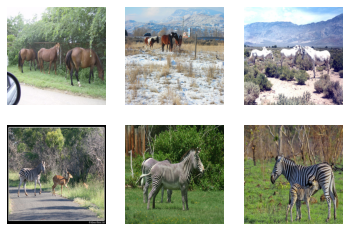

In [4]:
from numpy import load
from matplotlib import pyplot as plt

# Load data from .npz file
data = load("horse2zebra_256.npz")
dataA, dataB = data["arr_0"], data["arr_1"]
print("Loaded ", dataA.shape, dataB.shape)

# Plot sample images
n_samples = 3

# Plot source images
for i in range(n_samples):
  plt.subplot(2, n_samples, i+1)
  plt.axis('off')
  plt.imshow(dataA[i].astype('uint8'))

# Plot target images
for i in range(n_samples):
  plt.subplot(2, n_samples, i + n_samples + 1)
  plt.axis('off')
  plt.imshow(dataB[i].astype('uint8'))

plt.show()

In [5]:
# install keras-contrib.git for the instance normalization layer

!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-fms2mo30
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-fms2mo30
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=dcbe38943325f2c0d3df048040fde20e5f08dbab129a50ef43688f58f93ff38d
  Stored in directory: /tmp/pip-ephem-wheel-cache-pzuh3tnz/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


## Define discriminator

In [6]:
from random import random
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [7]:
def define_discriminator(image_shape):
  # Initialization
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  # C64
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C512
  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # Second last output layer
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # Patch output
  patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  # Define and compile Model
  model = Model(in_image, patch_out)
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])

  return model

## Define Generator

In [8]:
# Define the resnet block
def resnet_block(n_filters, input_layer):
  # Weight initialization
  init = RandomNormal(stddev=0.02)
  # First layer
  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
  # Second layer
  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  # Concat with input_layer to create skip connection
  g = Concatenate()([g, input_layer])
  return g

In [9]:
# Define generator
def define_generator(image_shape, n_resnets=9):
  # Weight initialization
  init = RandomNormal(stddev=0.02)
  # Image input
  in_image = Input(shape = image_shape)
  # C7s1-64
  g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
  # d128
  g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
  # d256
  g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
  # R256
  for _ in range(n_resnets):
    g = resnet_block(256, g)
  # u128
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)  
  # u64
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
  # c7s1-3
  g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  out_image = Activation('tanh')(g)
  # Define Model
  model = Model(in_image, out_image)
  return model


## Define composite model

In [10]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
  # Ensure g_model_1 is trainable while the other two not
  g_model_1.trainable = True
  d_model.trainable = False
  g_model_2.trainable = False
  # Discriminator element
  input_gen = Input(shape=image_shape)
  gen1_out = g_model_1(input_gen)
  output_d = d_model(gen1_out)
  # Identity element
  input_id = Input(shape=image_shape)
  output_id = g_model_1(input_id)
  # Forward cycle
  output_f = g_model_2(gen1_out)
  # Backward cycle
  gen2_out = g_model_2(input_id)
  output_b = g_model_1(gen2_out)
  # Define model graph
  model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  # compile model with weighting losses
  model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
  return model



## Load samples

In [11]:
def load_real_samples(filename):
  # load dataset
  data = load(filename)
  # unpack arrays
  X1, X2 = data['arr_0'], data['arr_1']
  # Scale to [-1, 1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]

def generate_real_samples(dataset, n_samples, patch_shape):
  # Choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return X, y

def generate_fake_samples(g_model, dataset, patch_shape):
  X = g_model.predict(dataset)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

## Define Save Generator Models

In [12]:
def save_models(step, g_model_AtoB, g_model_BtoA):
  filename1 = 'g_model_AtoB_%06d.h5' % (step + 1)
  filename2 = 'g_model_BtoA_%06d.h5' % (step + 1)

  g_model_AtoB.save(filename1)
  g_model_BtoA.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

def save_discriminators(step, d_model_A, d_model_B):
  filename1 = 'd_model_A%06d.h5' % (step+1)
  filename2 = 'd_model_B%06d.h5' % (step+1)
  d_model_A.save(filename1)
  d_model_B.save(filename2)
  print('Saved: %s and %s' % (filename1, filename2))

## Generate Models, save as plot, and save models

In [13]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
  # Select sample of real images
  X_in, _ = generate_real_samples(trainX, n_samples, 0)
  # Create generated images
  X_out, _ = generate_fake_samples(g_model, X_in, 0)
  # Scale outputs from [-1, 1] to [0, 1]
  X_in = (X_in + 1) / 2
  X_out = (X_out + 1) / 2
  # Plot real images
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(X_in[i])
  # Plot generated images
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(X_out[i])

  # Save plot to file
  filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
  plt.savefig(filename1)
  plt.close()

## Update image pool

In [14]:
def update_image_pool(pool, images, max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
      # Stock pool
      pool.append(image)
      selected.append(image)
    elif random() < 0.5:
      # Use image but don't add to pool
      selected.append(image)
    else:
      # Replace an existing image and use image
      ix = randint(0, len(pool))
      selected.append(pool[ix])
      pool[ix] = image
  
  return asarray(selected)

## Define Train

In [15]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, C_model_BtoA, dataset):
  # Initialize variables
  n_epochs, n_batch = 100, 1
  n_patch = d_model_A.output_shape[1]
  poolA, poolB = list(), list()
  # Unpack dataset
  trainA, trainB = dataset
  batch_per_epoch = int(len(trainA) / n_batch)
  n_steps = batch_per_epoch * n_epochs
  
  for i in range(n_steps):
    # Select a batch of real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    # Generate a bunch of fake samples
    X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
    # Update fakes from pool
    X_fakeA = update_image_pool(poolA, X_fakeA)
    X_fakeB = update_image_pool(poolB, X_fakeB)
    # Update generator B to A using adversarial and cycle loss
    g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
    # Update discriminator for A
    dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
    dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
    # Update generator A to B using adversarial and cycle loss
    g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
    # Update discriminator for B
    dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
    dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
    # Summarize performance
    print(">%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]" % (i+1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))

    if (i+1) % (batch_per_epoch * 1) == 0:
      # Plot summary of A->B performance
      summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
      # Plot summary of B->A performance
      summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
    if (i+1) % (batch_per_epoch * 5) == 0:
      # Save the model
      save_models(i, g_model_AtoB, g_model_BtoA)
      save_discriminators(i, d_model_A, d_model_B)



## Run and Train

In [ ]:
# Load image data
dataset = load_real_samples('horse2zebra_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# Define input shape
image_shape = dataset[0].shape[1:]
# Define generators
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
# Define discriminators
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
# Define composite models
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# Train model
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)


Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)
>1, dA[1.018,0.973] dB[1.575,1.300] g[17.726,17.245]
